In [1]:
import datetime

import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
def importdata():
    dataframe = pd.read_csv('../data/df_points_18-19-20-21_v1_weather_final.csv')
    return dataframe.sort_values(by=['dt_start'])

# Main

In [61]:
df = importdata()
df = df.reset_index(drop=True)
df = df.fillna(0)

df.drop(['time_start','time_end'], axis=1, inplace=True)


In [62]:
## Feature hex_id encoding
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
df['hex_enc']= label_encoder.fit_transform(df['hex_id'])

#del hex_id
del df['hex_id']

In [ ]:
# Add start time Feature
df['start_min'] = np.nan
for ind in tqdm(df.index):
    df['start_min'][ind] = (df['dt_start'][ind] % 86400) / 60

 90%|███████████████████████████▊   | 2186784/2435439 [11:09<00:56, 4409.90it/s]

# Main

In [6]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# read CSV
df = pd.read_csv('../data/df_points_18_21_v1_new_features.csv')

In [7]:
# event del Index Column
del df['Unnamed: 0']
df['idle_time'] = df['timestood'].copy()
del df['timestood']
df = df.sort_values(by='dt_start', ignore_index=True)
df.head()

,bike_id,lat,lng,temp,rain,snow,dt_start,dt_end,hex_enc,start_min,idle_time
0,3694,51.323619,12.335887,10.80,0.0,0.0,1514764029,1514764799,324,1427.15,12
1,2508,51.323619,12.335887,10.80,0.0,0.0,1514764035,1514764799,324,1427.25,12
2,41851,51.332415,12.395158,10.80,0.0,0.0,1514764638,1514764799,137,1437.30,2
3,2508,51.323619,12.335887,10.86,0.0,0.0,1514764800,1514851199,324,0.00,1439
4,3694,51.323619,12.335887,10.86,0.0,0.0,1514764800,1514814103,324,0.00,821


In [8]:
TargetVariable=['idle_time']
Predictors=['bike_id', 'lat', 'lng', 'temp', 'rain', 'snow', 'dt_start','hex_enc','start_min']

In [9]:
X=df[Predictors].values
y=df[TargetVariable].values

### Sandardization of data ###
from sklearn.preprocessing import StandardScaler
PredictorScaler=StandardScaler()
TargetVarScaler=StandardScaler()

# Storing the fit object for later reference
PredictorScalerFit=PredictorScaler.fit(X)
TargetVarScalerFit=TargetVarScaler.fit(y)

# Generating the standardized values of X and y
X=PredictorScalerFit.transform(X)
y=TargetVarScalerFit.transform(y)


# Split the data into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Quick sanity check with the shapes of Training and testing datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1948351, 9)
(1948351, 1)
(487088, 9)
(487088, 1)


In [39]:
# Get best Params
# solver & activisions

from sklearn.neural_network import MLPRegressor
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

solvers = ['lbfgs','sgd','adam']
activisions = ['identity','logistic','tanh','relu']

resultsr2 = []
resultsmse = []

for solver in tqdm(solvers):
    for activation in activisions:
        nn = MLPRegressor(hidden_layer_sizes=(10,15), activation=activation, solver=solver, max_iter=100, verbose=0)
        nn.fit(X_train,y_train.ravel())

        expected_y = y_test
        predicted_y = nn.predict(X_test)

        r2 = metrics.r2_score(expected_y,predicted_y)
        mse = metrics.mean_squared_error(expected_y,predicted_y)

        resultsr2.append((solver + activation, r2))
        resultsmse.append((solver + activation, mse))


  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/Caskroom/miniconda/base/envs/geobike/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/Caskroom/miniconda/base/envs/geobike/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/Caskroom/miniconda/base/envs/geobike/lib/python3.9/site-packag

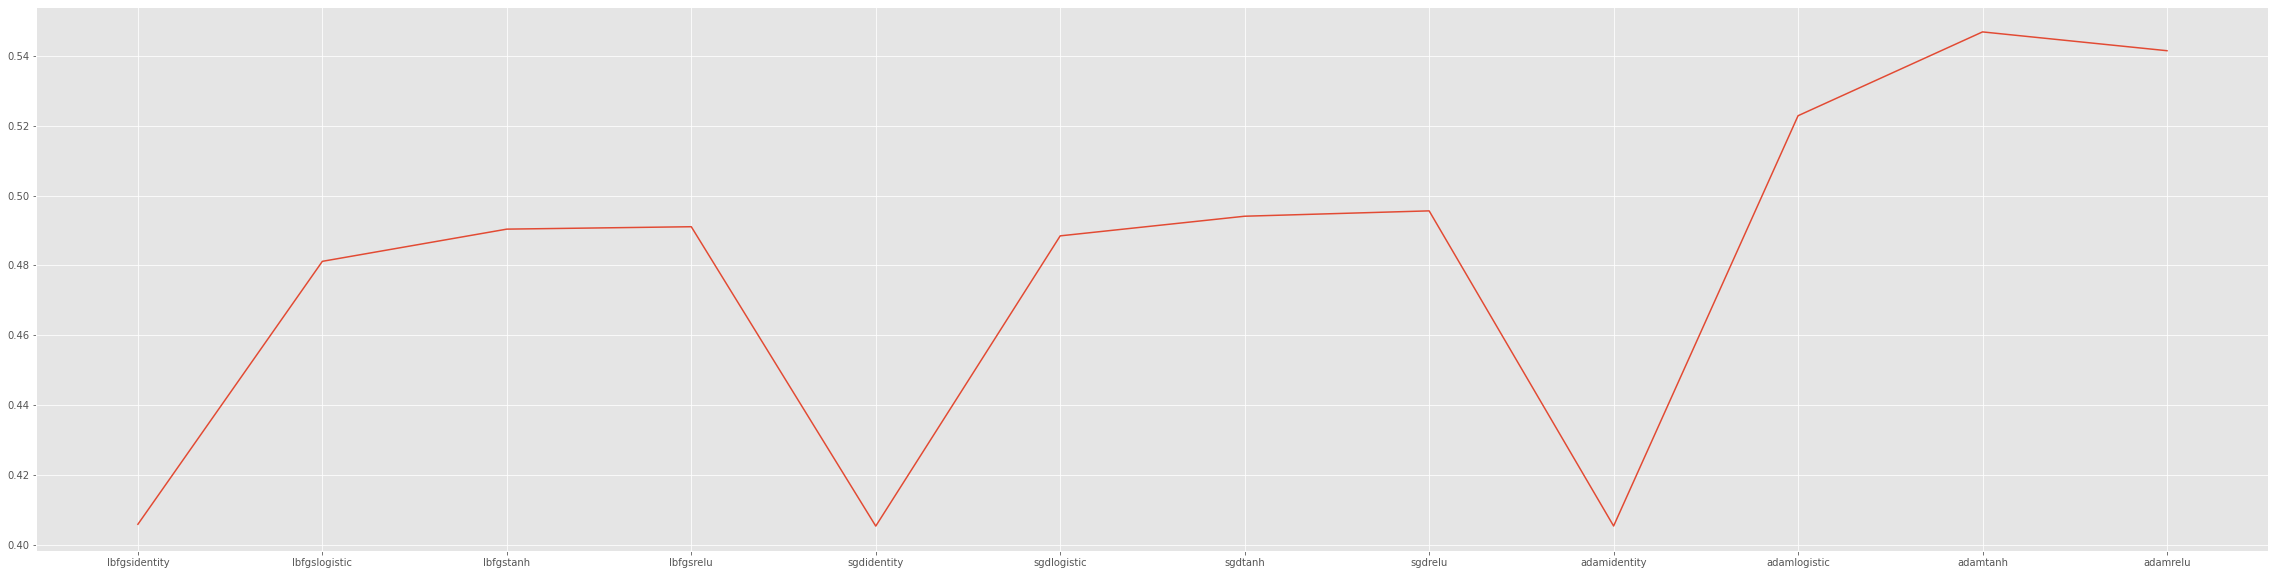

In [47]:
# plot params
x = []
y = []
for tuple in resultsr2:
    x.append(tuple[0])
    y.append(tuple[1])
plt.figure(figsize=(40,10))
plt.plot(x,y)

# Compare Algorithms

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

import warnings
from sklearn.exceptions import ConvergenceWarning


# Spot Check Algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('NN', MLPRegressor(hidden_layer_sizes=(10,15,10), activation='tanh', solver='adam', max_iter=1000, verbose=0, early_stopping=True)))
models.append(('KNN', KNeighborsRegressor()))
models.append(('RF', RandomForestRegressor(n_estimators = 100))) # Ensemble method - collection of many decision trees
# Evaluate each model in turn
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
    tscv = TimeSeriesSplit(n_splits=10)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=ConvergenceWarning)
        cv_results = cross_val_score(model, X_train, y_train.ravel(), cv=tscv, scoring='r2')

    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

LR: 0.407329 (0.001798)
NN: 0.551628 (0.010378)
KNN: 0.470671 (0.013228)
RF: 0.611413 (0.015212)


# Use best params
# MLPRegressor

In [52]:
nn = MLPRegressor(hidden_layer_sizes=(10,15,10), activation='tanh', solver='adam', max_iter=1000, verbose=1, early_stopping=True)
nn.fit(X_train,y_train.ravel())

expected_y = y_test
predicted_y = nn.predict(X_test)

r2 = metrics.r2_score(expected_y,predicted_y)
mse = metrics.mean_squared_error(expected_y,predicted_y)
print(f"R2: {r2}")
print(f"MSE: {mse}")

Iteration 1, loss = 0.26010076
Validation score: 0.495594
Iteration 2, loss = 0.25406200
Validation score: 0.497350
Iteration 3, loss = 0.25255239
Validation score: 0.501675
Iteration 4, loss = 0.25105596
Validation score: 0.502950
Iteration 5, loss = 0.24995999
Validation score: 0.504755
Iteration 6, loss = 0.24898963
Validation score: 0.505243
Iteration 7, loss = 0.24762756
Validation score: 0.509398
Iteration 8, loss = 0.24601315
Validation score: 0.513092
Iteration 9, loss = 0.24408712
Validation score: 0.514259
Iteration 10, loss = 0.24284466
Validation score: 0.519531
Iteration 11, loss = 0.24197963
Validation score: 0.520721
Iteration 12, loss = 0.24120409
Validation score: 0.519631
Iteration 13, loss = 0.24005121
Validation score: 0.525381
Iteration 14, loss = 0.23871060
Validation score: 0.525688
Iteration 15, loss = 0.23704714
Validation score: 0.532980
Iteration 16, loss = 0.23504212
Validation score: 0.537349
Iteration 17, loss = 0.23340153
Validation score: 0.538995
Iterat

# Gridsearch
# RandomForestRegressor

In [10]:
import sklearn.metrics as metrics

def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred)
    mse=metrics.mean_squared_error(y_true, y_pred)
    #mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))
    #print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [11]:
from sklearn.metrics import make_scorer

def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score

rmse_score = make_scorer(rmse, greater_is_better = False)

In [12]:
# Param Grid Search
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit

model = RandomForestRegressor()
param_search = {
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)],
    'verbose' : [1]
}
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score)
gsearch.fit(X_train, y_train.ravel())
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    7.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   15.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   24.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

In [13]:
y_true = y_test
y_pred = best_model.predict(X_test)

regression_results(y_true, y_pred)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


explained_variance:  0.5895
r2:  0.5895
MAE:  0.46
MSE:  0.411
RMSE:  0.6411


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.1s finished


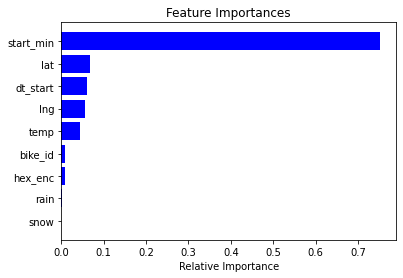

In [15]:
import matplotlib.pyplot as plt

imp = best_model.feature_importances_
X_train = pd.DataFrame(X_train,columns=Predictors)
features = X_train.columns
indices = np.argsort(imp)
plt.title('Feature Importances')
plt.barh(range(len(indices)), imp[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# inverse transformation y_test y_pred

In [58]:
# transform back
#X_back = PredictorScalerFit.inverse_transform(X)
predicted_y = predicted_y.reshape(-1, 1)
y_real_back = TargetVarScalerFit.inverse_transform(y_test)
y_pred_back =  TargetVarScalerFit.inverse_transform(predicted_y)

In [59]:
result_compare = pd.DataFrame(y_real_back,columns=['real'])

In [61]:
result_compare['pred'] = y_pred_back

In [62]:
result_compare

,real,pred
0,648.0,1144.472840
1,38.0,120.372312
2,1439.0,865.256972
3,268.0,865.532030
4,902.0,300.368490
...,...,...
487083,498.0,272.307613
487084,82.0,241.258410
487085,175.0,348.363753
487086,306.0,259.579036
